# Via Data Challenge

## Problem Statement

Via is considering expansion into one (or both) of the following possible days/times:
* weekends
* late nights (e.g., midnight to 2 a.m.)

**Analysis Questions:**

1. Which of the options is ***most beneficial*** and why?
2. If launching on weekends, should the service be provided during 'normal' hours (6:30 a.m. - midnight)?
3. Should the new service(s) be launched in Via's **entire** service area?  Or should the service be limited to certain areas/customers?
4. Should the ***pricing*** remain consistent with weekday pricing (5 dollars before 9 p.m. and 8 dollars after)?  Is this reasonable for the proposed expansion?  If not, how much should Via charge for rides? Why?

**Qualitative Questions:**

5. What ***additional data*** would help in answering questions 1 through 3?  How would the new data be incorporated?
6. How might the answer to this question ***change over time***?  What Via data should be monitored to ensure proposed expansion was a good business decision?

To answer these questions, we will make use of the NYC Taxi data set which can be found at:

* [the NYC TLC website](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml)
* [Google BigQuery](https://bigquery.cloud.google.com/table/imjasonh-storage:nyctaxi.trip_data)

## Import Libraries

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats, integrate
from matplotlib import rcParams
import seaborn as sns
% matplotlib inline

## Read in and Clean Data

Read in the taxi data (I chose to work with the Jan. 2015 data specifically) which was acquired from nyc.gov.  

To speed things up (the file for just one month is over 2 GB), I've broken the file up into weekdays vs. weekend days... and also split each day up by hour. 

Most of the cleaning was performed in a different script (viaDataChallengeCleaning.py).  This was necessary because the full data file kept crashing my browser when I tried to perform the cleaning in an iPython notebook.  The cleaning script is included for the interested reader.

In [2]:
# weekday df's for via's normal operating hours:
#   * the day df's have been split into smaller hourly df's
#   * the hourly df's are stored in a list for easier access later
wkday_normalhours_df_list = []
for i in range(7, 24):
    filename = "data/jan2015_wkday_" + str(i) + ".csv"
    wkday_normalhours_df_list.append(pd.read_csv(filename))

# the full daily df comes in handy too, so we build it as well
wkday_normalhours_df = pd.DataFrame()
for i in range(len(wkday_normalhours_df_list)):
    wkday_normalhours_df = wkday_normalhours_df.append(wkday_normalhours_df_list[i])

    
# we do the same thing for the weekend days
#   * the df's for Saturday/Sunday are split into hourly df's
#   * for the time being, the assumption is that operating hours will be
#     the same as weekdays.  we'll investigate this later.
wkend_normalhours_df_list = []
for i in range(7, 24):
    filename = "data/jan2015_wkend_" + str(i) + ".csv"
    wkend_normalhours_df_list.append(pd.read_csv(filename))

# construct the full weekend df
wkend_normalhours_df = pd.DataFrame()
for i in range(len(wkend_normalhours_df_list)):
    wkend_normalhours_df = wkend_normalhours_df.append(wkend_normalhours_df_list[i])
    
# finally, we build the df's for the "late night" hours of midnight - 2 a.m.
# the weekday late night hours:
wkday_0_df = pd.read_csv("data/jan2015_wkday_0.csv")
wkday_1_df = pd.read_csv("data/jan2015_wkday_1.csv")
wkday_latenight_df = wkday_0_df.append(wkday_1_df)

# the weekend late night hours:
wkend_0_df = pd.read_csv("data/jan2015_wkend_0.csv")
wkend_1_df = pd.read_csv("data/jan2015_wkend_1.csv")
wkend_latenight_df = wkend_0_df.append(wkday_1_df)

## Looking for Potential Via Customers in the Taxi Data

To explore the opportunities for Via to move into new days and times, I am going to focus on cab riders who would ***benefit the most from using Via*** (pricewise).

To be conservative, these are riders that are ***paying more than a 10 dollar fare***.  Since many cab rides involve more than one passenger, I will look at cab rides with a fare-per-passenger larger than 10 dollars.

I first want to investigate what ***ratio of cab rides have fares-per-passenger higher than 10 dollars*** for our given time periods:
* Via's normal operating hours (as a baseline)
* the weekday "late night" hours
* the weekend days (including the possibility of  "late night hours)

**NOTES**: 
* in cleaning the data, I have used the 'fare_amount' and 'passenger_count' columns to define a 'fare_per_passenger' column.
* from this point on, I will refer to rides with fares-per-passenger greater than 10 dollars as ***"high-fare" rides***

First, let's take a look at the ratio for Via's current operating days and times.

In [3]:
# first, pick out the high-fare rides
wkday_normalhours_large_fare_df = \
    wkday_normalhours_df[wkday_normalhours_df['fare_per_passenger'] >= 10.0]

# compute the percentage of high-fare rides by dividing the total number of 
# rides for this time period
wkday_normalhours_large_fare_pct =  \
    wkday_normalhours_large_fare_df.shape[0] / wkday_normalhours_df.shape[0]
    
print "Via's Current Operating days and times"
print "--------------------------------------"
print "Percent. of cab rides w/ Fares per passenger > $10: ",\
        100* round(wkday_normalhours_large_fare_pct, 4), '%'

Via's Current Operating days and times
--------------------------------------
Percent. of cab rides w/ Fares per passenger > $10:  32.25 %


So, it appears that (during Via's normal operating days/times) around ***32% of cab rides are "high-fare."***  

How does this compare to the percentage of ***fares on the weekend*** (assuming the same operating hours)?

In [4]:
# first, pick out the high-fare rides
wkend_normalhours_large_fare_df = \
    wkend_normalhours_df[wkend_normalhours_df['fare_per_passenger'] >= 10.0]

# compute the percentage of high-fare rides by dividing the total number of 
# rides for this time period
wkend_normalhours_large_fare_pct =  \
    wkend_normalhours_large_fare_df.shape[0] / wkend_normalhours_df.shape[0]
    
print "Weekends with Operating Hours between 6:30 a.m. and midnight"
print "------------------------------------------------------------"
print "Percent. of cab rides w/ Fares per passenger > $10: ",\
        100* round(wkend_normalhours_large_fare_pct, 4), '%'

Weekends with Operating Hours between 6:30 a.m. and midnight
------------------------------------------------------------
Percent. of cab rides w/ Fares per passenger > $10:  30.54 %


Hmm... ***slightly lower***.  We'll look into this in more detail in a minute.

Let's now take a look at the ***"late night" hours during the weekdays.***

In [5]:
# first, pick out the high-fare rides
wkday_latenight_large_fare_df = \
    wkday_latenight_df[wkday_latenight_df['fare_per_passenger'] >= 10.0]

# compute the percentage of high-fare rides by dividing the total number of 
# rides for this time period
wkday_latenight_large_fare_pct =  \
    wkday_latenight_large_fare_df.shape[0] / wkday_latenight_df.shape[0]
    
print "Late Weekday Nights with Operating Hours midnight and 2 a.m."
print "------------------------------------------------------------"
print "Percent. of cab rides w/ Fares per passenger > $10: ",\
        100* round(wkday_latenight_large_fare_pct, 4), '%'

Late Weekday Nights with Operating Hours midnight and 2 a.m.
------------------------------------------------------------
Percent. of cab rides w/ Fares per passenger > $10:  36.59 %


Wow, a ***fairly significant rise in the percentage of high-fare rides after midnight***.  This could make sense since people leaving this late from work (or leaving 'happy hour') might be more inclined to pay a little more for a cab instead of walking to a subway station and riding the subway home (or their next destination).  

Does the same thing occur on ***weekend late nights***?

In [6]:
# first, pick out the high-fare rides
wkend_latenight_large_fare_df = \
    wkend_latenight_df[wkend_latenight_df['fare_per_passenger'] >= 10.0]

# compute the percentage of high-fare rides by dividing the total number of 
# rides for this time period
wkend_latenight_large_fare_pct =  \
    wkend_latenight_large_fare_df.shape[0] / wkend_latenight_df.shape[0]
    
print "Late Weekend Nights with Operating Hours midnight and 2 a.m."
print "------------------------------------------------------------"
print "Percent. of cab rides w/ Fares per passenger > $10: ",\
        100* round(wkend_latenight_large_fare_pct, 4), '%'

Late Weekend Nights with Operating Hours midnight and 2 a.m.
------------------------------------------------------------
Percent. of cab rides w/ Fares per passenger > $10:  35.92 %


Yes!  So, it seems safe to say that ***weekday/weekend late nights have a larger percentage of high-fare rides***.

However, let's try to get some additional insight by investigating what the data ***looks like*** on an ***hourly basis*** for the weekday and weekends.  To do this, let's recombine the "normal hours" and "late hours" df's to get a feel of what a ***full day*** looks like.

Again, we are only focusing on *** high-fare rides ***.

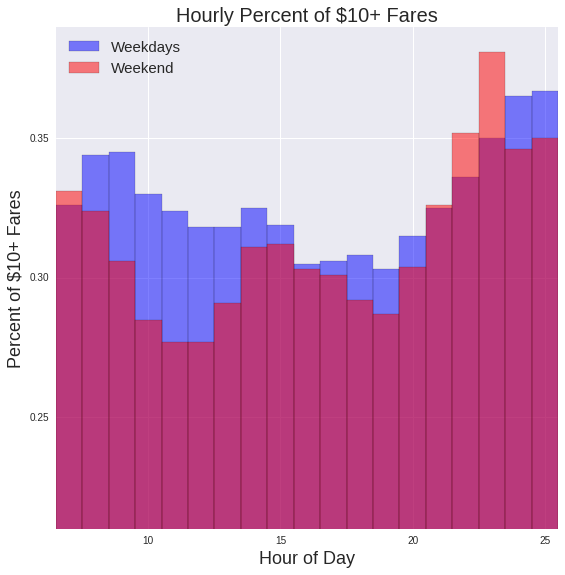

In [7]:
# first, append the "late hours" onto the normal hours list:
wkday_normalhours_df_list.append(wkday_0_df)
wkday_normalhours_df_list.append(wkday_1_df)

wkend_normalhours_df_list.append(wkend_0_df)
wkend_normalhours_df_list.append(wkend_1_df)

# construct lists for hours and percentages (for plotting):
wkday_hours = []
wkday_percentages = []
for i, df in enumerate(wkday_normalhours_df_list):
    df = df[df['fare_per_passenger'] >= 10.0]
    wkday_hours.append(i + 7)
    wkday_percentages.append(round(df.shape[0] / \
                        wkday_normalhours_df_list[i].shape[0], 3))

wkend_hours = []
wkend_percentages = []
for i, df in enumerate(wkend_normalhours_df_list):
    df = df[df['fare_per_passenger'] >= 10.0]
    wkend_hours.append(i + 7)
    wkend_percentages.append(round(df.shape[0] / \
                        wkend_normalhours_df_list[i].shape[0], 3))

# make the plot
fig = plt.figure(figsize=(9,9))
ax = plt.subplot(111)

ax.bar(wkday_hours, wkday_percentages, width=1, 
       color='b', align='center', alpha=0.5, label='Weekdays')
ax.bar(wkend_hours, wkend_percentages, width=1, 
       color='r', align='center', alpha=0.5, label='Weekend')

plt.xlim([6.5, 25.5])
plt.ylim([0.21, .39])

plt.title('Hourly Percent of $10+ Fares', fontsize=20)
plt.ylabel('Percent of $10+ Fares', fontsize=18)
plt.xlabel('Hour of Day', fontsize=18)
plt.legend(loc='upper left', fontsize=15)
plt.show()

Don't worry... there are still only 24 hours in a day ;)  The 24th and 25th bins represent the midnight - 1 a.m. and 1 a.m. - 2 a.m. periods, respectively.

**Takeaways from this plot**

* the weekday "late hours" have the ***largest percentage of high-fare rides*** for the entire day.

* on the weekend, the morning to early afternoon hours show a ***substantial deficiency in high-fare rides*** (compared to weekdays).  

* However, starting shortly after noon on the weekend, the ***number of high-fare cab rides picks up*** and becomes comparable to the number on weekdays.  Then, around 6 or 7 p.m., the percentage climbs dramatically up to around midnight (where it hits a weekly high).  This late evening spike makes sense as it can be accounted for by people "going out" for the night.

## Finding Via's New Customers

Having investigated the issue of what days/times Via should possibly expand into, let's now see if we can ***locate certain regions of NYC*** where potential Via customers would be.  Again, we are ***only focusing on the high-fare rides***.

To do this, we can use the ***geospatial information from the NYC taxi data to identify pickup locations***.  This may help to narrow the service area during these extended hours and make for a more efficient operation.

To visualize the locations of riders, we can make use of [CartoDB](https://cartodb.com/) which provides a lot of really interesting tools to visualize geographical data.

First, we further prune the data and only include the geospatial and timestamp data.

Also, to keep the maps from being "overpopulated" with data points, I've randomly sampled a smaller subset of data from the df's (e.g., the plots show 100000 data points).

**NOTE**: The maps below are ***fully-interactive*** allowing for zooming in and out as well as moving the map around.  ***Try it out... it's fun!*** ;)

In [8]:
# clean data for CartoDB
cartodb_df = wkend_latenight_large_fare_df

cartodb_df = cartodb_df[['pickup_latitude', 
                         'pickup_longitude', 
                         'tpep_pickup_datetime']]

cartodb_df = cartodb_df.rename(columns = {'tpep_pickup_datetime': 'time',
                                          'pickup_latitude': 'latitude', 
                                          'pickup_longitude': 'longitude'})

cartodb_df = cartodb_df.sample(n=100000)
cartodb_df.to_csv('wkend-latenight.csv')

**Weekday Normal Hours**

Here we see the situation during Via's ***normal operating days/hours***.  

As expected, ***mid-town is a hot bed*** for high-fare rides.  However, it is easy to see that other areas (e.g., the ***Upper East Side*** as well as certain ***areas of downtown***) can account for a ***large number*** of the high-fare rides.

In [9]:
from IPython.display import HTML
HTML('<iframe width="75%" height="520" frameborder="0" src="https://chrisjackson4256.cartodb.com/viz/40596258-e0e3-11e5-b165-0e8c56e2ffdb/embed_map" allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')

**Weekend Normal Hours**

Next, we consider the ***weekend during "normal" operating hours*** (6:30 a.m. - midnight).

To the naked eye, it is really difficult to spot differences between this map and the weekday map.  By zooming in, though, ***small differences are observable*** (such as a dip in rides originating in the ***Financial District***).

In [10]:
HTML('<iframe width="75%" height="520" frameborder="0" src="https://chrisjackson4256.cartodb.com/viz/87aec57a-e0e4-11e5-abe3-0ef24382571b/embed_map" allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')

**Weekday and Weekend Latenights**

During the ***weekday*** (top plot) and ***weekend*** (bottom plot) ***late nights***, there is a ***noticeable drop*** in high-fare rides ***originating from uptown*** and, at the same time, a ***substantial increase*** of high-fare rides ***originating from downtown***.  

***Greenwich Village*** and the ***Lower East Side*** (where a large number of bars are located), in particular, show ***dramatic increases*** in the numbers of high-fare rides.

In [11]:
HTML('<iframe width="75%" height="520" frameborder="0" src="https://chrisjackson4256.cartodb.com/viz/d2ce7c2a-e0e5-11e5-a919-0e98b61680bf/embed_map" allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')

In [12]:
HTML('<iframe width="75%" height="520" frameborder="0" src="https://chrisjackson4256.cartodb.com/viz/d9558c4a-e0e6-11e5-83e3-0e8c56e2ffdb/embed_map" allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')

## Visualizing the Time-evolution of High-Fare Rides

Given the size of the NYC data set, it is actually possible to ***make a "map" of NYC just using the pick-up locations***.  This was originally done by Daniel Forsyth in this [blog post](http://www.danielforsyth.me/mapping-nyc-taxi-data/).

I thought it might be interesting to take this mapping one step further and produce GIFs which show the time-evolution of **high-fare rides** for weekdays and weekends.

Below is the code used to produce a set of plots (one for each hour) using the high-fare df's.  These plots were then assembled to produce ***time-lapsed pictures of taxi pickups in Manhattan***.  The times are printed in the lower right corner of the plots.

In [13]:
#pd.options.display.mpl_style = 'default' #Better Styling  
#new_style = {'grid': False} #Remove grid  
#matplotlib.rc('axes', **new_style)  
#rcParams['figure.figsize'] = (17, 17.5) #Size of figure  
#rcParams['figure.dpi'] = 250
#
#for i in range(len(wkend_normalhours_df_list)):
#    P = wkend_normalhours_df_list[i].plot(kind='scatter', 
#    		x='pickup_longitude', y='pickup_latitude',
#    		color='white', xlim=(-74.03,-73.95),
#    		ylim=(40.7, 40.8), s=.02,alpha=.6)
#
#    P.set_axis_bgcolor('black') #Background Color
#    
#    P.text(0.95, 0.01, 'Time = {}:00 - {}:00'.format(i + 7, i + 8),
#        verticalalignment='bottom', horizontalalignment='right',
#        transform=P.transAxes,
#        color='red', fontsize=20)
#    
#    filename = 'figs/fig' + str(i + 7) + '.png'
#    
#    P.figure.savefig(filename) 

** Weekdays ** 

It is interesting to see the ***location of high-fare rides*** (which are fairly evenly distributed at 7 a.m.) ***shift with time***.  In particular, shortly after 7-8 p.m., there is a clear shift from uptown (e.g., the Upper East Side) to downtown as restaurant/bar customers become the leading high-fare riders. 

In [14]:
from IPython.display import Image
Image(url='http://pivot-basketball.com/static/img/manhattan-taxi-weekday.gif', width=750, height=750)

** Weekends **

Again, the location of high-fare rides is fairly evenly-distributed on the weekends.

It is interesting to see that the ***spike in high-fare rides*** around 11 p.m to midnight (pointed out in the histogram above) is ***clearly evident*** in this GIF.

In [15]:
from IPython.display import Image
Image(url='http://pivot-basketball.com/static/img/manhattan-taxi-weekend.gif', width=750, height=750)

## Proposals for expansion of Via's Service Days/Hours

In summary, we have used the NYC taxi data to investigate the question of whether or not Via should consider expanding their service to latenights and/or the weekends.  To identify potential Via customers, we have limited our focus to "high-fare" cab rides (i.e., those with a fare-per-passenger of more than 10 dollars).

The first question we attempted to answer was which option(s) would provide the best opportunities for Via.  To do this, we looked at the percentage of high-fare rides for the days and times of interest.

First, we saw that the highest percentage of high-fare rides on weekdays actually occur between midnight and 2 a.m.  Thus, this could be a very promising time slot for Via to acquire new customers (especially among the younger "demographics" who are presumably using cabs during this time period to get home from bars and restaurants).

We also saw that the percentages of weekend morning high-fare cab rides tend to be far below those of weekday morning rides.  However, starting in the early afternoon, the amount of high-fare cab rides starts to rise sharply (probably as people start to go out for the night) and reaches the highest peak (for all days of the week!) near the 11 p.m. to midnight time span. Because of this, service over a limited number of hours on the weekend also looks to be promising.

Next, we used the geolocational data contained in the NYC taxi data set to try to identify areas of the city where Via could narrow its focus to.  We found that the distribution of high-fare rides on the weekend was fairly well-distributed and (besides some small fluctuations) was very similar to the distribution on weekdays.  This seems to warrant Via keeping their normal range of service for the weekends.  Late night high-fare rides tend to be dominated by those originating in downtown, so it might be more cost-effective and efficient to center service around that area of the city.

In conclusion, I believe that it would be beneficial for Via to consider expanding their service to both:

* weekday late nights (midnight to 2 a.m.)
* weekends with hours limited to late-morning/early-afternoon to 2 a.m. 

in that order (if a multi-stage expansion is preferred).  We have seen from the NYC taxi data that there is clearly a market for the late hours (especially on weekdays) and some of the highest percentages for high-fare rides occur on weekend evenings.  Service areas should remain relatively unchanged for these new days/times with maybe an exception on late nights where a heavier concentration of attention on downtown spots may be beneficial. 

Regarding pricing during these extended hours, I believe a 10-20% increase above current pricing is completely warranted considering the probable clientele (i.e., young professionals and tourists) and the unique and convenient service provided.

Lastly, other data that would have proven useful in this analysis would have included analogous data from Via itself as well as data from Uber and Lyft.  Given more time, I would have also liked to explore monthly and/or seasonal changes in the patterns observed in this study.  This would be an important piece of information as it is easily conceivable that these patterns may change from season to season.  Much like many businesses which shift their hours with the season, it might be more cost-effective for Via to shift the extended hours based on seasons and holidays.

Thanks for this opportunity! (If you can't tell, I had a lot of fun with this challenge! ;)

Chris Jackson